![giskard_logo.png](https://raw.githubusercontent.com/Giskard-AI/giskard/main/readme/Logo_full_darkgreen.png)

# About Giskard

Open-Source CI/CD platform for ML teams. Deliver ML products, better & faster. 

*   Collaborate faster with feedback from business stakeholders.
*   Deploy automated tests to eliminate regressions, errors & biases.

🏡 [Website](https://giskard.ai/)

📗 [Documentation](https://docs.giskard.ai/)

## Installing `giskard`

In [1]:
!pip install giskard

## Connect the external worker in daemon mode

In [2]:
!giskard worker start -d

# Start by creating an ML model 🚀🚀🚀

Let's create a credit scoring Model using the German Credit scoring dataset [(Link](https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification) to download the dataset)

In [3]:
import pandas as pd

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [4]:
# To download and read the credit scoring dataset
url = 'https://raw.githubusercontent.com/Giskard-AI/examples/main/datasets/credit_scoring_classification_model_dataset/german_credit_prepared.csv'
credit = pd.read_csv(url, sep=',',engine="python") #To download go to https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification

In [5]:
# Declare the type of each column in the dataset(example: category, numeric, text)
column_types = {'default':"category",
               'account_check_status':"category", 
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_employment_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_residence_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

In [6]:
# feature_types is used to declare the features the model is trained on
feature_types = {i:column_types[i] for i in column_types if i!='default'}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys() if feature_types[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types.keys() if feature_types[key]=="category"]
categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False)) ])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_to_scale),
      ('cat', categorical_transformer, columns_to_encode)
          ]
)

# Pipeline for the model Logistic Regression
clf_logistic_regression = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter =1000))])

# Split the data into train and test
Y = credit['default']
X= credit.drop(columns="default")
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20,random_state = 30, stratify = Y)

In [7]:
# Fit and score your model
clf_logistic_regression.fit(X_train, Y_train)
clf_logistic_regression.score(X_test, Y_test)



C:\Users\AHMED-YASSINE\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.755

To make sure that we need to do Data Augmentation on our dataset, we can verify the porpotion of the two classes in it.
Here is a representation of the ratios in the $\mathtt{credit}$ dataset : 

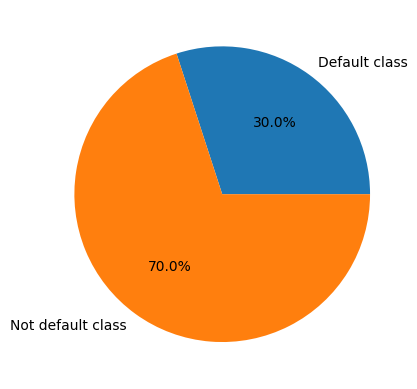

In [8]:

# Converting the default column from 'Default' and 'Not default' values to 0 and 1
Y_numeric = [1 if label == 'Default' else 0 for label in Y]

#ratio of default/not default
default = 100*sum(Y_numeric)/len(Y_numeric)
not_default = 100 - default

#Pie plot
fig, ax = plt.subplots()
ax.pie([default, not_default], labels=['Default class', 'Not default class'], autopct='%1.1f%%')

plt.show()

So we can see that our data set is very imbalanced ( $ 70\% $ to $ 30\% $ ), which can affect negatively the performance of our model. That's why we need to do some data augmentation to have a balanced data set and to build a model that performs better.

Also, when dealing with imbalanced dataset, it is prefered to use the **F1 score** as metric, because using accuracy as the metric to evaluate a Machine Learning model that was trained with an imbalanced dataset the results can be misleading

Let's check the F1 score of our previous model :

In [9]:
# Building the predictions list 
Y_pred = clf_logistic_regression.predict(X_test) 

# Converting the Y_pred and Y_test lists to 0 and 1 (1  for 'Default' and 0 for 'Not default')
y_pred_numeric = [1 if label == 'Default' else 0 for label in Y_pred]
y_true_numeric = [1 if label == 'Default' else 0 for label in Y_test]

# using the sklearn.metrics function to compute the f1 score :
F1_score1 = f1_score(y_true_numeric, y_pred_numeric)
print("The F1 score of the first model is : ", F1_score1)





The F1 score of the first model is :  0.5663716814159292


As we can see, the F1 score of the first model is very low even if its accuracy is $0.755$. Which shows how misleading can be the accuracy on imbalanced datasets. So for what's coming, **we use the F1 score as a metric.**

## Data Augmentation of our dataset

### SMOTE technique :  

The Data Augmentation is well known on tha image classification field using CNN, but we can also use it on tabular datasets like ours with differents techniques. 

There is a lot of strategies to do it on tabular data, like Over sampling (generating new sample of the minority class) or Under sampling (randomly deleting samples from majority class) or generating synthetical data from the original.

The first technique we are using is the SMOTE ( Synthetic Minority Over-sampling Technique ), which is an over sampling technique that stands on the nearest neighbours algorithm to generate new samples to generate samples from minority class to balance the data set. We are going to generate new data and retrain our model on it to see if ot performance is better. We are going to call this model the SMOTE model.

The $\mathtt{imblearn}$ python package contains SMOTE method and other methods for imbalanced data sets. We are going to use the SMOTENC function to generate new samples, it is the same as SMOTE but can deal with categorical features too.


In [10]:
#!pip install imblearn
from imblearn.over_sampling import SMOTENC

#### SMOTE on all dataset

The SMOTENC function takes the index of categorical features as an argument, and has the fit_resample method that generates new samples.

                


In [11]:
# creating the indexes of categorical features list
features =     {'account_check_status':"category", 
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_employment_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_residence_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

#Getting the indexes of categorical columns
category_indexes = [index for index, value in enumerate(features.values()) if value == 'category']

#Defining the SMOTENC function
smotenc = SMOTENC(categorical_features = category_indexes)

# Generating new data using fit_resample method
X_smote, Y_smote = smotenc.fit_resample(X,Y)

We can check if the new data is balanced : 

The size of new data :  1400


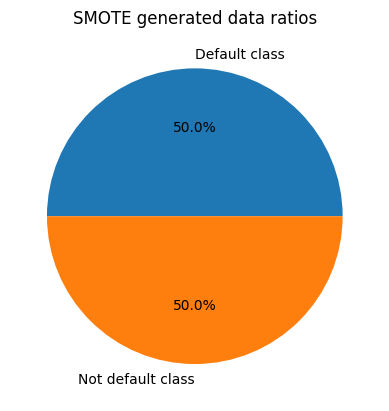

In [12]:
print("The size of new data : ", len(Y_smote))

Y_smote_num = [1 if label == 'Default' else 0 for label in Y_smote]
default = 100*sum(Y_smote_num)/len(Y_smote_num)
not_default = 100 - default

fig, ax = plt.subplots()
ax.pie([default, not_default], labels=['Default class', 'Not default class'], autopct='%1.1f%%')
plt.title("SMOTE generated data ratios")
plt.show()

As we can see, the new data is perfectly balanced. The SMOTENC function generated $400$ new samples of minority class.
We can also tale a look on the generated data to see if it is coherent : 


In [13]:
X_smote.tail()

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_employment_since,installment_as_income_perc,sex,personal_status,...,present_residence_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
1395,< 0 DM,17,existing credits paid back duly till now,(vacation - does not exist?),1807,... < 100 DM,4 <= ... < 7 years,3,female,divorced,...,1,real estate,22,stores,own,1,skilled employee / official,1,none,yes
1396,< 0 DM,23,existing credits paid back duly till now,business,7499,... < 100 DM,.. >= 7 years,2,female,divorced,...,2,unknown / no property,51,none,own,1,management/ self-employed/ highly qualified em...,1,none,yes
1397,< 0 DM,27,existing credits paid back duly till now,domestic appliances,3130,... < 100 DM,... < 1 year,2,female,divorced,...,3,if not A121 : building society savings agreeme...,31,none,own,1,skilled employee / official,1,none,yes
1398,0 <= ... < 200 DM,11,existing credits paid back duly till now,car (new),904,... < 100 DM,.. >= 7 years,4,male,divorced,...,3,"if not A121/A122 : car or other, not in attrib...",22,bank,own,1,skilled employee / official,1,none,yes
1399,0 <= ... < 200 DM,45,existing credits paid back duly till now,car (new),6553,... < 100 DM,.. >= 7 years,2,male,single,...,1,unknown / no property,25,none,own,1,skilled employee / official,1,none,yes


Now we can retrain our logistic regression model on the new data and test its performance on the validation datasets : 

In [14]:
#Creating new learning and test datasets
X_train2, X_test2, Y_train2, Y_test2 = model_selection.train_test_split(X_smote, Y_smote, test_size=0.20,random_state = 30, stratify = Y_smote)

#Using the same Pipeline as the first model 
clf_logistic_regression.fit(X_train2, Y_train2)

C:\Users\AHMED-YASSINE\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.7928571428571428

In [15]:
# Prediction the target column from the test dataset
Y_pred2 = clf_logistic_regression.predict(X_test2) 

y_pred_numeric2 = [1 if label == 'Default' else 0 for label in Y_pred2]
y_true_numeric2 = [1 if label == 'Default' else 0 for label in Y_test2]

#comutiong F1 score
F1_score1 = f1_score(y_true_numeric2, y_pred_numeric2)
print("The F1 score of the SMOTE model is : ", F1_score1)

The F1 score of the SMOTE model is :  0.7972027972027972


#### SMOTE on underperforming data slices

The previous work has been done on dataset without focusing on data slices that underperform. In the exercices we were given four data slices that underperfomed in using the first model. 


Our strategy here to fix that using the SMOTE method is to generate new samples based on these data slices and to add them to the full data set then retrain the model again.

In [16]:
#getting the data slices that underperformed under the first model :

slice1 = credit[credit['duration_in_month'] == 36 ]
slice2 = credit[credit['credit_history'] == 'all credits at this bank paid back duly']
slice3 = credit[credit['account_check_status'] == '< 0 DM']
slice4 = credit[credit['purpose'] == 'Other'] # we have noticed that this data slices is empty as the 'purpose'
                                             # columns doesn't have 'other' case so we keep only the first three data slices
                                                    
Y_slice1 = slice1['default']
X_slice1 = slice1.drop(columns="default")


Y_slice2 = slice2['default']
X_slice2 = slice2.drop(columns="default")


Y_slice3 = slice3['default']
X_slice3 = slice3.drop(columns="default")


In [17]:

# Generating new samples of each data slice 
X1_smote, Y1_smote = smotenc.fit_resample(X_slice1,Y_slice1)
X2_smote, Y2_smote = smotenc.fit_resample(X_slice2,Y_slice2)
X3_smote, Y3_smote = smotenc.fit_resample(X_slice3,Y_slice3)
# Some of them can overlap ang we will have duplicated lines, we are going to deal with that after !

In [18]:
# Concatenating the three data sets so as we can delete duplicate lines after
df1_over = pd.concat([X1_smote, Y1_smote], axis = 1)
df2_over = pd.concat([X2_smote, Y2_smote], axis = 1)
df3_over = pd.concat([X3_smote, Y3_smote], axis = 1)

df_smote2 = pd.concat([credit, df1_over, df2_over, df3_over], axis = 0)

# dropping duplicate lines and spliting into validation and training data
credit2 = df_smote2.drop_duplicates()


X_smote2 = credit2.drop(columns='default')
Y_smote2 = credit2['default']

#Creating another validation and test datasets
X_train3, X_test3, Y_train3, Y_test3 = model_selection.train_test_split(X_smote2, Y_smote2, test_size=0.20,random_state = 30, stratify = Y_smote2)

The model accuracy has improved compared to the first model ($0.755$). But is can be mislaeding as we have said so let's see the F1 score

In [20]:
#Fitting the model and predicting the target from th test dataset
clf_logistic_regression.fit(X_train3, Y_train3)
Y_pred3 = clf_logistic_regression.predict(X_test3)

y_pred_numeric3 = [1 if label == 'Default' else 0 for label in Y_pred3]
y_true_numeric3 = [1 if label == 'Default' else 0 for label in Y_test3]

F1_score2 = f1_score(y_true_numeric3, y_pred_numeric3)
print("The F1 score of the SMOTE model is : ", F1_score1)

The F1 score of the SMOTE model is :  0.7972027972027972


Great ! The F1 score is very high, the SMOTE startegy has improved the performance of our model.

### GAN technique

The second technique we are going to use is called **GAN** (Generative Adversarial Networks). GAN is a synthetic data generation technique and it is extremely popular in image, video and voice generation and Even if it not very popular on tabular data, it can be used to generate synthectic data sets from an original data. 

GAN is simply a combination of two neural networks: Generator and Discriminator. Generator, using some random noise as input, tries to mimic the real data and Discriminator tries to classify the data into real and fake.

To do that, we have to build the two neural networks and train them on our data. We are going to use the $\mathtt{CTGAN()}$ function from the $\mathtt{ctgan}$ package which create the neural network and return it back and it has $\mathtt{sample}$ method that generates synthectic data.

In [149]:
from ctgan import CTGAN
import random


In [22]:
ctgan = CTGAN(epochs=30) # creating the GAN neural network

#fitting the GAN to our data, we give the names of categorical columns too
ctgan.fit(credit, ['default'] + columns_to_encode)

#Generating synthetic data
credit_synth = ctgan.sample(1000)

Lets take a look at our synthetic generated data :

In [22]:
print("There is ", 100*sum(credit_synth['default'] == 'Default')/credit_synth.shape[0], "% of class 'Default' samples")
print("There is ", 100 - 100*sum(credit_synth['default'] == 'Default')/credit_synth.shape[0], "% of class 'Not default' samples")

There is  40.7 % of class 'Default' samples
There is  59.3 % of class 'Not default' samples


We notice that the generated data is imbalanced, that's because the GAN learns from the original data set, which is also imbalanced.
So working on these new data samples will give bad results that can be worse than the first model.

So to deal with this problem we have two options : 


   - Either we train our GAN on a balanced data set, and we can do it by extracting a balanced subset from the original data then train the GAN on it to generate new synthetical balanced data set.
    
   - Either we train 3 GANs on the three data slices that underperforms and then we generate new data based on these slices.
    
    

#### First option : training the gan on a balanced data subset

As the original data set contains $300$ samples from 'default' class, we can extract few samples from the 'Not default' class to create the imbalanced data subset toward minority class so wa can sample a lot of 'Default' class samples.

In [150]:
#Extracting lines from 'Default' / 'Not default' class
default_cl = credit[credit['default'] == 'Default']

not_default_cl = credit[credit['default'] == 'Not default'].sample(170)

# Concatinating both subsets
sub_credit = pd.concat([default_cl, not_default_cl], axis = 0)

In [154]:
random.seed(35)
# creating our new GAN, fitting it and sampling new data
ctgan1 = CTGAN(epochs=5, batch_size = 100, 
              embedding_dim=50, generator_dim=(20, 20), discriminator_dim=(20, 20))


ctgan.fit(sub_credit, ['default'] + columns_to_encode)
credit_synth = ctgan.sample(1000)

In [155]:
print("There is ", 
      100*sum(credit_synth['default'] == 'Default')/credit_synth.shape[0], 
      "% of class 'Default' samples") 


print("There is ", 
      100 - 100*sum(credit_synth['default'] == 'Default')/credit_synth.shape[0], 
      "% of class 'Not default' samples")

There is  79.4 % of class 'Default' samples
There is  20.599999999999994 % of class 'Not default' samples


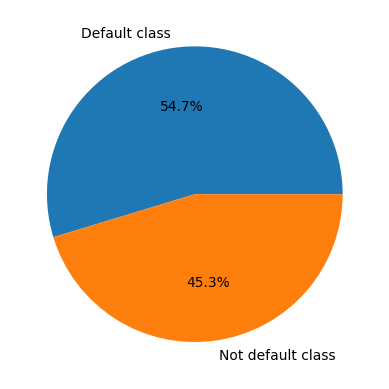

In [156]:
credit_gan = pd.concat([credit, credit_synth], axis = 0)

credit_gan['credit_amount'] = abs(credit_gan['credit_amount'])


Y_gan = credit_gan['default']
X_gan = credit_gan.drop(columns="default")

Y_numeric_gan = [1 if label == 'Default' else 0 for label in Y_gan]
default = 100*sum(Y_numeric_gan)/len(Y_numeric_gan)
not_default = 100 - default

fig, ax = plt.subplots()
ax.pie([default, not_default], labels=['Default class', 'Not default class'], autopct='%1.1f%%')

plt.show()

In [157]:

X_train_gan, X_test_gan, Y_train_gan, Y_test_gan = model_selection.train_test_split(X_gan, Y_gan, test_size=0.20 ,random_state = 35, stratify = Y_gan)
clf_logistic_regression.fit(X_train_gan, Y_train_gan)

Y_pred_gan = clf_logistic_regression.predict(X_test_gan)

y_pred_numeric_gan = [1 if label == 'Default' else 0 for label in Y_pred_gan]
y_true_numeric_gan = [1 if label == 'Default' else 0 for label in Y_test_gan]

print("The GAN model F1 score is : ", f1_score(y_true_numeric_gan, y_pred_numeric_gan))


The GAN model F1 score is :  0.7441860465116279


C:\Users\AHMED-YASSINE\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The F1 score of this model is slightly higher than the first model ($0.567$), but it is lower than the SMOTE model.  
Let's see how it does perform when we focus only on data slices that underperform

#### Training on data slices that underperformed

In [146]:
random.seed(45)
ctgan_slice1 = CTGAN(epochs = 3, batch_size = 20)
                    
ctgan_slice2 = CTGAN(epochs = 3, batch_size = 20)
                    
ctgan_slice3 = CTGAN(epochs = 3, batch_size = 20)
                

ctgan_slice1.fit(slice1, ['default'] + columns_to_encode)
ctgan_slice2.fit(slice2, ['default'] + columns_to_encode)
ctgan_slice3.fit(slice3, ['default'] + columns_to_encode)

synth_slice1 = ctgan_slice1.sample(50, condition_column='default', condition_value='Default')
synth_slice2 = ctgan_slice1.sample(50, condition_column='default', condition_value='Default')
synth_slice3 = ctgan_slice1.sample(50, condition_column='default', condition_value='Default')

In [147]:
credit_gan_2 = pd.concat([credit, synth_slice1, synth_slice2, synth_slice3], axis = 0)
credit_gan_2['credit_amount'] = abs(credit_gan_2['credit_amount'])

Y_gan2 = credit_gan_2['default']
X_gan2 = credit_gan_2.drop(columns="default")


X_train_gan2, X_test_gan2, Y_train_gan2, Y_test_gan2 = model_selection.train_test_split(X_gan2, Y_gan2, test_size=0.20 ,random_state = 30, stratify = Y_gan2)


In [148]:
clf_logistic_regression.fit(X_train_gan2, Y_train_gan2)

Y_pred_gan2 = clf_logistic_regression.predict(X_test_gan2)


y_pred_numeric_gan2 = [1 if label == 'Default' else 0 for label in Y_pred_gan2]
y_true_numeric_gan2 = [1 if label == 'Default' else 0 for label in Y_test_gan2]

print("The GAN model F1 score is : ", f1_score(y_true_numeric_gan2, y_pred_numeric_gan2))



The GAN model F1 score is :  0.6370370370370371


C:\Users\AHMED-YASSINE\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The ***F1 score** of this method is also slightly higher than the fisrt model which can be acceptable.

## Conclusion :

In this notbook we've seen two methods of augmenting our data to improve the classification model. The original data was imbalanced which caused the model to not perform well (**F1 SCORE = 0.567**). We decided to consider the F1 score as the metric because when dealing with imbalanced datasets, the other metrics such as precision or accuracy can give misleading results.

The first method is SMOTE, it gave F1 score around **0.78** when samples are generated based on the full dataset, and an F1 score around **0.79** when focused on data slices that underperform which shows great improvement compared to the original model

The GAN method on the other hand, didn't perform as high as the SMOTE but it did improve the first model at least. The resulting F1 scores were around **0.7** when training the GAN on all the data set and around **0.6** when we focus on data slices that underperformed on the first model. Both results are still better than the first model.
